In [1]:
import pandas as pd

df = pd.read_csv("电量数据.csv")

df

,时间,7月1日,7月2日,7月3日,7月4日,7月5日,7月6日,7月7日,7月8日,7月9日,...,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96
0,0:15,11.496,11.242,11.312,11.080,9.994,11.555,11.509,7.770,11.705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0:30,10.711,10.487,9.980,9.912,8.021,11.675,10.505,10.926,9.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0:45,12.548,12.568,11.148,11.937,11.552,11.678,11.399,10.211,10.882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1:00,10.835,12.901,10.529,11.075,10.692,12.107,10.473,11.150,10.451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1:15,11.454,12.403,10.478,11.462,10.243,12.271,10.489,11.930,11.255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,23:00,10.869,9.590,9.240,11.326,8.998,9.868,8.475,8.252,8.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,23:15,13.050,11.487,9.702,12.144,11.196,11.451,9.761,9.594,9.433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,23:30,11.151,9.226,8.683,10.715,9.603,9.749,8.124,8.013,8.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,23:45,11.907,9.733,9.545,11.947,9.647,9.919,8.025,9.374,8.833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import pandas as pd

# 使用 melt 函数将数据列转换为新的格式
melted_df = pd.melt(df, id_vars=["时间"], var_name="日期", value_name="数据")

# 添加日期前缀并调整时间格式
melted_df["日期"] = "2023/" + melted_df["日期"] + " " + melted_df["时间"]
melted_df.drop(columns=["时间"], inplace=True)

# 打印结果
print(melted_df)

                             日期      数据
0                2023/7月1日 0:15  11.496
1                2023/7月1日 0:30  10.711
2                2023/7月1日 0:45  12.548
3                2023/7月1日 1:00  10.835
4                2023/7月1日 1:15  11.454
...                         ...     ...
9211     2023/Unnamed: 96 23:00     NaN
9212     2023/Unnamed: 96 23:15     NaN
9213     2023/Unnamed: 96 23:30     NaN
9214     2023/Unnamed: 96 23:45     NaN
9215  2023/Unnamed: 96 24:00:00     NaN

[9216 rows x 2 columns]


In [3]:
df = melted_df.dropna()

In [4]:
df

,日期,数据
0,2023/7月1日 0:15,11.496
1,2023/7月1日 0:30,10.711
2,2023/7月1日 0:45,12.548
3,2023/7月1日 1:00,10.835
4,2023/7月1日 1:15,11.454
...,...,...
2971,2023/7月31日 23:00,9.005
2972,2023/7月31日 23:15,9.860
2973,2023/7月31日 23:30,9.743
2974,2023/7月31日 23:45,12.128


## 如此就转化为了按照时点变化的时间序列数据，下面进行预测，预测未来一天的数据

In [5]:
#!/usr/bin/env python
# coding: utf-8
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential


#忽略警告
import warnings
warnings.filterwarnings("ignore")
#如果没有这个目录，则创建这个目录
if not os.path.isdir('result'):
    os.mkdir('result')

In [6]:
#定义稳定性检验函数
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)

    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # 返回adf值、adf的p值、三种状态的检验值

In [7]:
#白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。
def acorr_val(ts):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # 白噪声检验结果
    return lbvalue, pvalue



def tsplot(y, lags=None, figsize=(15, 8)):
    fig = figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('origin  data')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    #自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
    plot_acf(y, lags=lags, ax=acf_ax)
    #可以度量现在值与过去值更纯正的相关性
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/ACF_PACF.png')#图片保存路径
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [8]:
ts_data = df["数据"]
ts_data

0       11.496
1       10.711
2       12.548
3       10.835
4       11.454
         ...  
2971     9.005
2972     9.860
2973     9.743
2974    12.128
2975     9.715
Name: 数据, Length: 2976, dtype: float64

In [9]:
#平稳性检验
adf1, pvalue1, critical_values1 = adf_val(ts_data, 'raw time series') #对原数据进行平稳性判断
print('adf',adf1)
print('pvalue1',pvalue1)
print('critical_values',critical_values1)
#结果显示，adf结果为-2.2394..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的

#白噪声检验
aco=acorr_val(ts_data)
print('aco',aco)


[('adf', -6.4839573744419665), ('pvalue', 1.2745345140596395e-08), ('usedlag', 27), ('nobs', 2948), ('critical_values', {'1%': -3.4325701503289845, '5%': -2.8625209161584713, '10%': -2.5672921685377847}), ('icbest', 7684.080748077922)]
adf -6.4839573744419665
pvalue1 1.2745345140596395e-08
critical_values {'1%': -3.4325701503289845, '5%': -2.8625209161584713, '10%': -2.5672921685377847}
aco ('lb_stat', 'lb_pvalue')


## 检验结果显示，时间序列的数据是平稳的，不需要一阶差分，可以直接下一步得出参数

(<AxesSubplot:title={'center':'origin  data'}>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

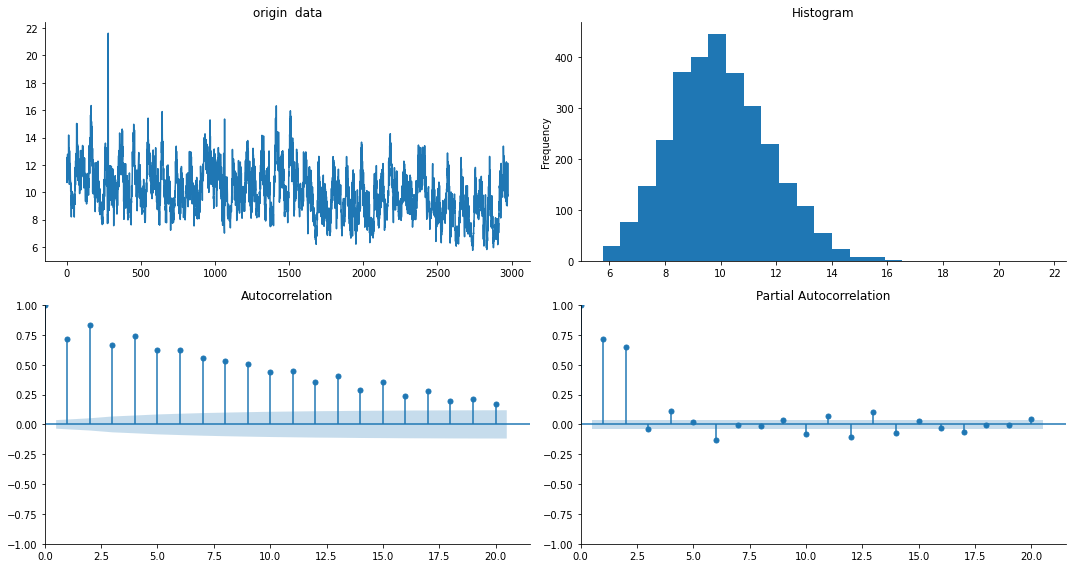

In [66]:
##显示原数据（未差分）的自相关ACF和偏自相关PACF
tsplot(ts_data, lags=20)

这段代码用于寻找ARIMA模型的最佳参数组合，其中使用AIC指标来评估不同参数组合的性能，并选择AIC值最低的参数组合作为最佳参数。

In [12]:
#下面这段用于寻找arima参数，若不会用可不用
#确定ARIMA的p、q、d参数，
#一种方式可以根据上述的ACF图和PACF图来确定，但通常由于主观性，不好确定；
#另一种方式可以用个AIC或者BIC指标进行选取参数，这里用AIC进行确定，采用网格搜索进行寻参

# #AIC和BIC计算最好的pdq值
q_arima = range(0, 3)#定义q值的范围
d_arima = 0 #d值为差分项，若原数据平稳不需要进行差分则d=0,否则d为原始数据差分稳定的阶数
p_arima = range(0, 3)#定义p值的范围
AIC_arima = [] #定义AIC列表存储AIC值
ARIMAX_model = []#定义模型参数列表存储参数值
#循环各组参数来试验哪组参数比较好
pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]

from statsmodels.tsa.arima.model import ARIMA


for pdq in pdqs:
    mod =ARIMA(ts_data, order=pdq)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(pdq, results.aic))
    AIC_arima.append(results.aic)
    ARIMAX_model.append(pdq)
print('AIC_arima')
print(AIC_arima)

index=AIC_arima.index(min(AIC_arima))
order = ARIMAX_model[index]
print('order num',order)

ARIMA(0, 0, 0) - AIC:11798.875647605004
ARIMA(0, 0, 1) - AIC:10953.540145633468
ARIMA(0, 0, 2) - AIC:9407.26569337524
ARIMA(1, 0, 0) - AIC:9634.376021077358
ARIMA(1, 0, 1) - AIC:8594.37200963814
ARIMA(1, 0, 2) - AIC:8261.62196707319
ARIMA(2, 0, 0) - AIC:7993.2748697000025
ARIMA(2, 0, 1) - AIC:7989.693057904222
ARIMA(2, 0, 2) - AIC:7968.826451712706
AIC_arima
[11798.875647605004, 10953.540145633468, 9407.26569337524, 9634.376021077358, 8594.37200963814, 8261.62196707319, 7993.2748697000025, 7989.693057904222, 7968.826451712706]
order num (2, 0, 2)


In [16]:

order=(2,0,2)#有时候寻参出来的参数也不一定能用，可能需要调一下（出错情况下）

# # 构建训练数据
ndata=np.array(ts_data).reshape(-1,1)#转换数据格式为array类型（方便取值操作）
#划分训练集和测试集
train_len=int(len(ndata)*0.99)#取80%数据作为训练集
train_ar = ndata[:train_len,:]#取数据[行或行区间(:),列或列区间(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()

#训练ARIMA模型
for t in range(len(test_ar)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()#模型训练
    output = model_fit.forecast()#模型预测
    yhat = output[0]
    pre.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#数据类型转换
pre=np.array(pre)

<class 'list'>
predicted=12.021172, expected=12.633000
predicted=12.761532, expected=12.143000
predicted=12.181513, expected=12.666000
predicted=12.141922, expected=11.872000
predicted=12.212874, expected=11.413000
predicted=11.563860, expected=11.297000
predicted=11.312685, expected=11.209000
predicted=11.176585, expected=10.420000
predicted=10.896703, expected=11.104000
predicted=10.587668, expected=12.056000
predicted=11.292043, expected=10.785000
predicted=11.458102, expected=9.907000
predicted=10.452873, expected=9.563000
predicted=9.917445, expected=10.437000
predicted=9.889116, expected=11.959000
predicted=10.813432, expected=10.265000
predicted=11.234325, expected=9.324000
predicted=9.936225, expected=9.651000
predicted=9.602641, expected=10.064000
predicted=9.828273, expected=12.219000
predicted=10.617607, expected=9.990000
predicted=11.339097, expected=9.038000
predicted=9.651615, expected=9.874000
predicted=9.525735, expected=9.845000
predicted=9.891418, expected=10.416000
p

In [18]:
data = ts_data

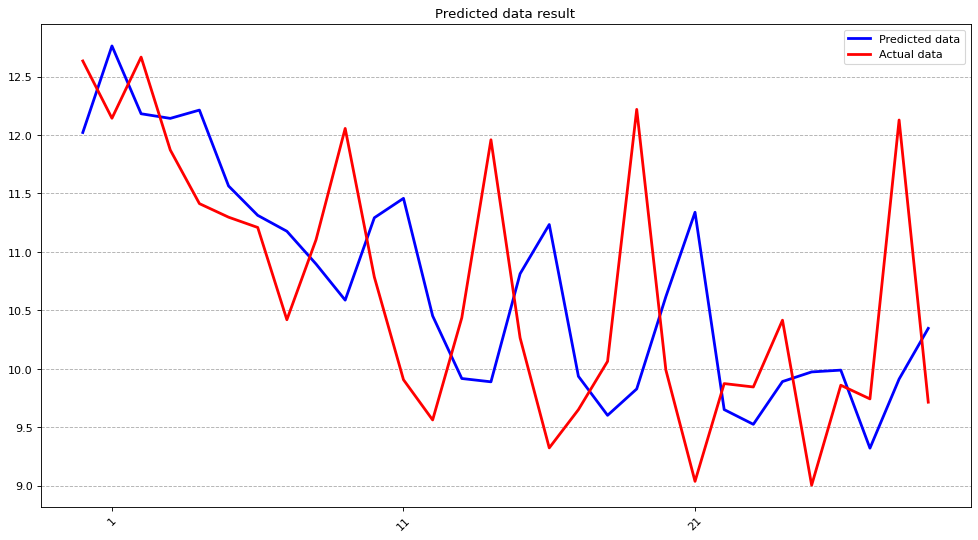

In [21]:
#显示预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(pre, label="Predicted data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(test_ar, label="Actual data", color='r',lw=2.5)
plt.title("Predicted data result")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.xticks(range(1,len(pre),10),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/predict_result.png')
plt.show()


In [22]:
forecast_steps = 96  # 要预测的步数
forecast = model_fit.forecast(steps=forecast_steps)

In [23]:
forecast

array([10.34631688, 11.41028341, 10.48328097, 11.1298338 , 10.54081182,
       10.9296107 , 10.55183015, 10.78187012, 10.53649101, 10.66911176,
       10.50705187, 10.58022404, 10.47089247, 10.50808758, 10.43238731,
       10.44808439, 10.39406605, 10.39716995, 10.35733184, 10.35329483,
       10.32290546, 10.31504379, 10.29109933, 10.28140998, 10.26198612,
       10.2516532 , 10.23550203, 10.22521061, 10.21150963, 10.20164002,
       10.18983579, 10.18058368, 10.17029416, 10.16174472, 10.15269825,
       10.14487175, 10.13686874, 10.12974846, 10.1226372 , 10.11618647,
       10.10984784, 10.10402028, 10.09835794, 10.09310356, 10.0880376 ,
       10.08330631, 10.07876909, 10.0745127 , 10.07044601, 10.06661927,
       10.06297244, 10.05953348, 10.056262  , 10.05317243, 10.05023694,
       10.04746186, 10.0448274 , 10.04233514, 10.03997056, 10.03773252,
       10.03561   , 10.03360039, 10.03169504, 10.02989063, 10.02818017,
       10.02656005, 10.0250245 , 10.02356989, 10.02219134, 10.02

In [26]:
forecast_df = pd.DataFrame({'Predicted Rate': forecast})

# 将DataFrame保存为Excel文件
forecast_df.to_excel('arima_forecast.xlsx', index=False)